## Insurance 회귀 분석 캡스톤
- 왜 어떤 사람의 의료보험 청구 비용은 높고 낮을까?
    - 나이, 성별, 거주 지역, 생활 습관에 따라 달라짐
    - 흡연 여부는 의료비를 얼마나 크게 변화시킬까?
    - 젊은 사람도 흡연자라면 높은 비용을 지불할까?
    - 개인의 인구학적 건강 특성이 의료보험 청구 비용을 어떤 구조로 설명하는지를 데이터와 회귀모형을 통해 단계적으로 탐구
    - 목표는 "의료 비용 불평등은 어떤 논리로 형성되는가" 를 수치와 언어로 설명하는 것

In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

from itertools import combinations

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [1]:
origin = load_data('insurance')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===== 데이터 크기 확인 =====
데이터셋 크기 : (1338, 7)
열 개수: 7
행 개수: 1338

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- 데이터 기본 전처리 -카테고리 타입 지정
- smoker 변수 no=0, yes=1로 변경

In [7]:
df_raw = origin.copy()
df_raw = df_raw.astype({'sex':'category','smoker':'category', 'region':'category'})

display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


None

### 미션 1. 이 데이터는 믿을만할까?
- 결측, 이상치, 편향을 점검하고, 처리 기준을 제시한다.
- charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
- 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 몰려 있지는 않는지 확인한다.
- 전처리 전,후가 어떻게 달라졌는지 한 눈에 비교하는 표나 요약을 만든다.
- 단위 해석 주의 : charges는 USD이므로 현실적인 의료비 수준인지 평가하세요.

#### 기술통계량 확인

In [8]:
# 수치형 요약 통계를 확인함
df_raw.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


데이터의 평균 분포가 서로 상이하므로 (특히 나이와 bmi) 로그나 데이터 표준화 등의 처리가 필요할듯

#### 2. 결측치 비율 확인

In [9]:
# 결측률을 내림차순으로 확인함
df_raw.isna().mean().sort_values(ascending=False)*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

- 결측치가 없음 ! ! ! 대박

#### 3. 중복행수

In [10]:
#중복 행 수를 집계함
df_raw.duplicated().sum()

np.int64(1)

중복 행이 하나 존재하므로 삭제

In [12]:
# 중복 행을 삭제함
df = df_raw.drop_duplicates().reset_index(drop=True)
df.shape

(1337, 7)

#### 4. charges의 값이 음수,극단인지, age/bmi의 범위가 현실적인지 확인

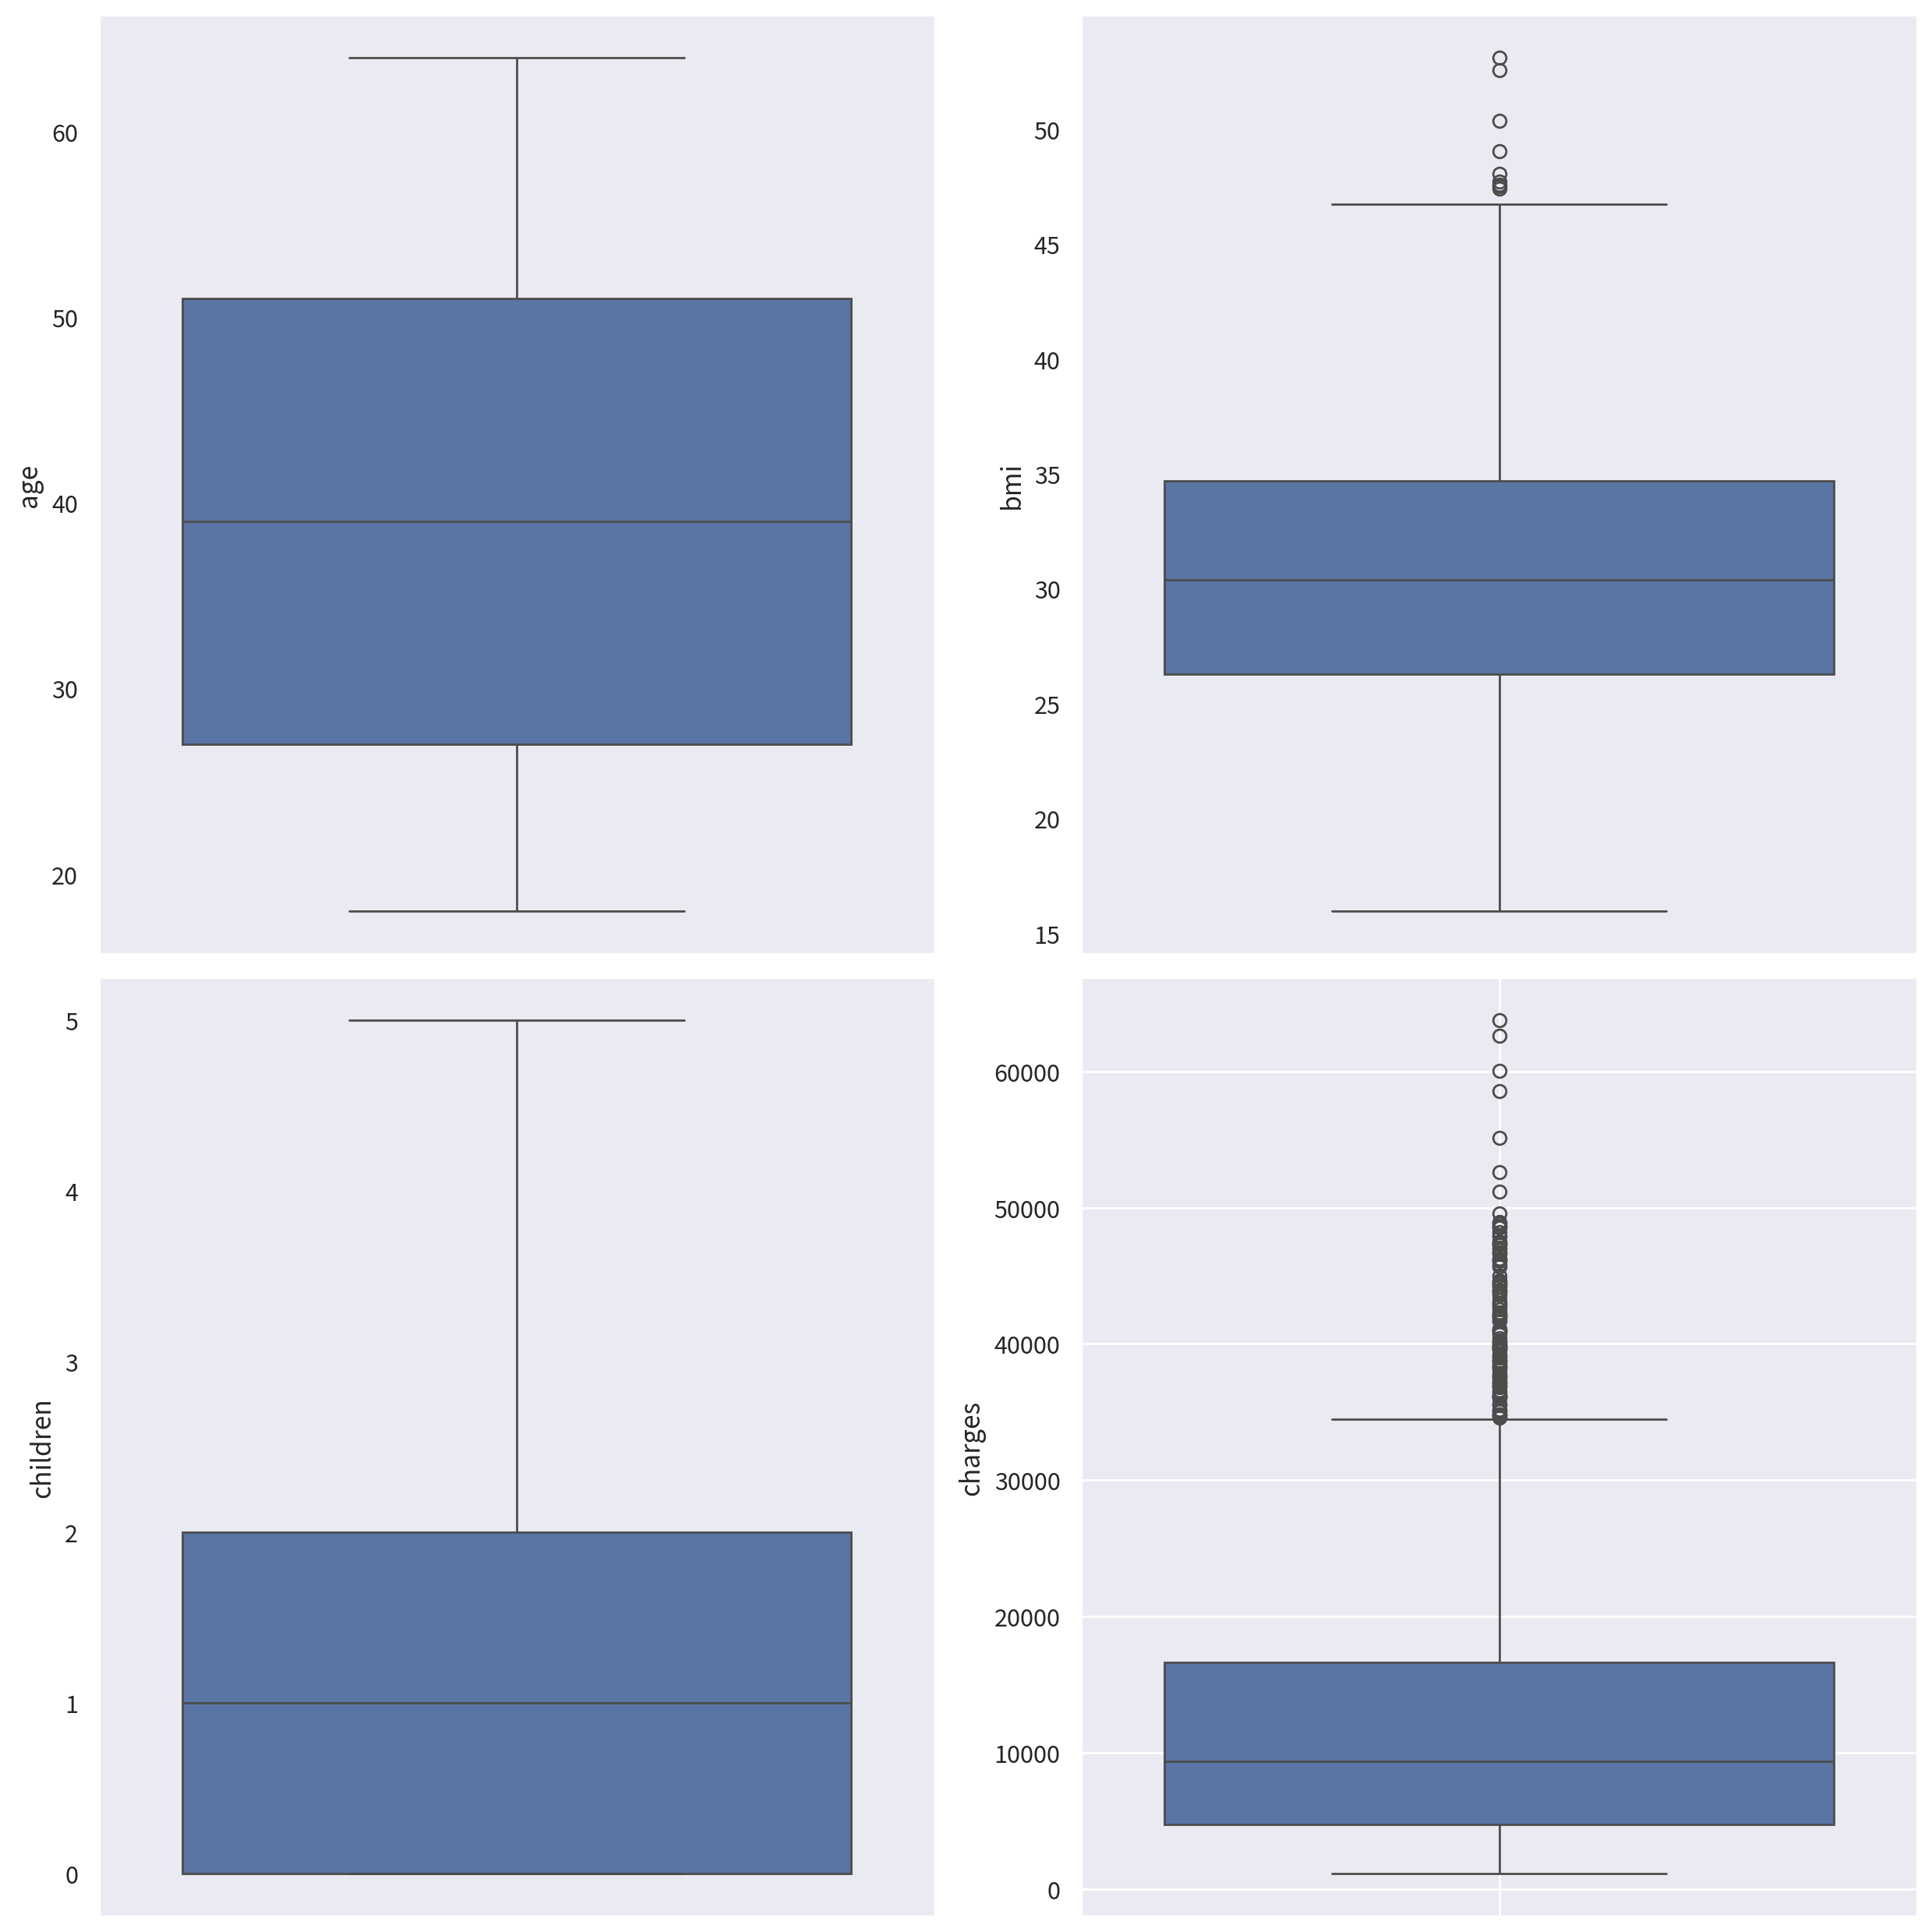

In [13]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df['age'],orient='v',ax=ax[0][0])
sb.boxplot(data=df['bmi'],orient='v',ax=ax[0][1])
sb.boxplot(data=df['children'],orient='v',ax=ax[1][0])
sb.boxplot(data=df['charges'],orient='v',ax=ax[1][1])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- BMI에 이상치가 발견되는데 max값이 53으로 현실적인 범위라고 생각할 수 있음. 
- 몸무게=55 x 키m^2 이니까 
    - 키가 160인 사람이 140.8키로 나가면 가능..
- charges의 최댓값이 63770USD 로 우리나라 돈으로 93,226,638원임.. 미국이라고 생각해도 값이 좀 이상한 느낌 하지만, 3.5만 달러~ 5만달러까지 데이터가 꽤 몰려있는 것을 보면 6만달러가 말이 안되는 가격이 아닐 수 있음.
    - 일단 그대로 두고 분석 진행

### 미션 2. 의료비와 핵심 변수의 첫인상
- 1. charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
- 4. 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요.

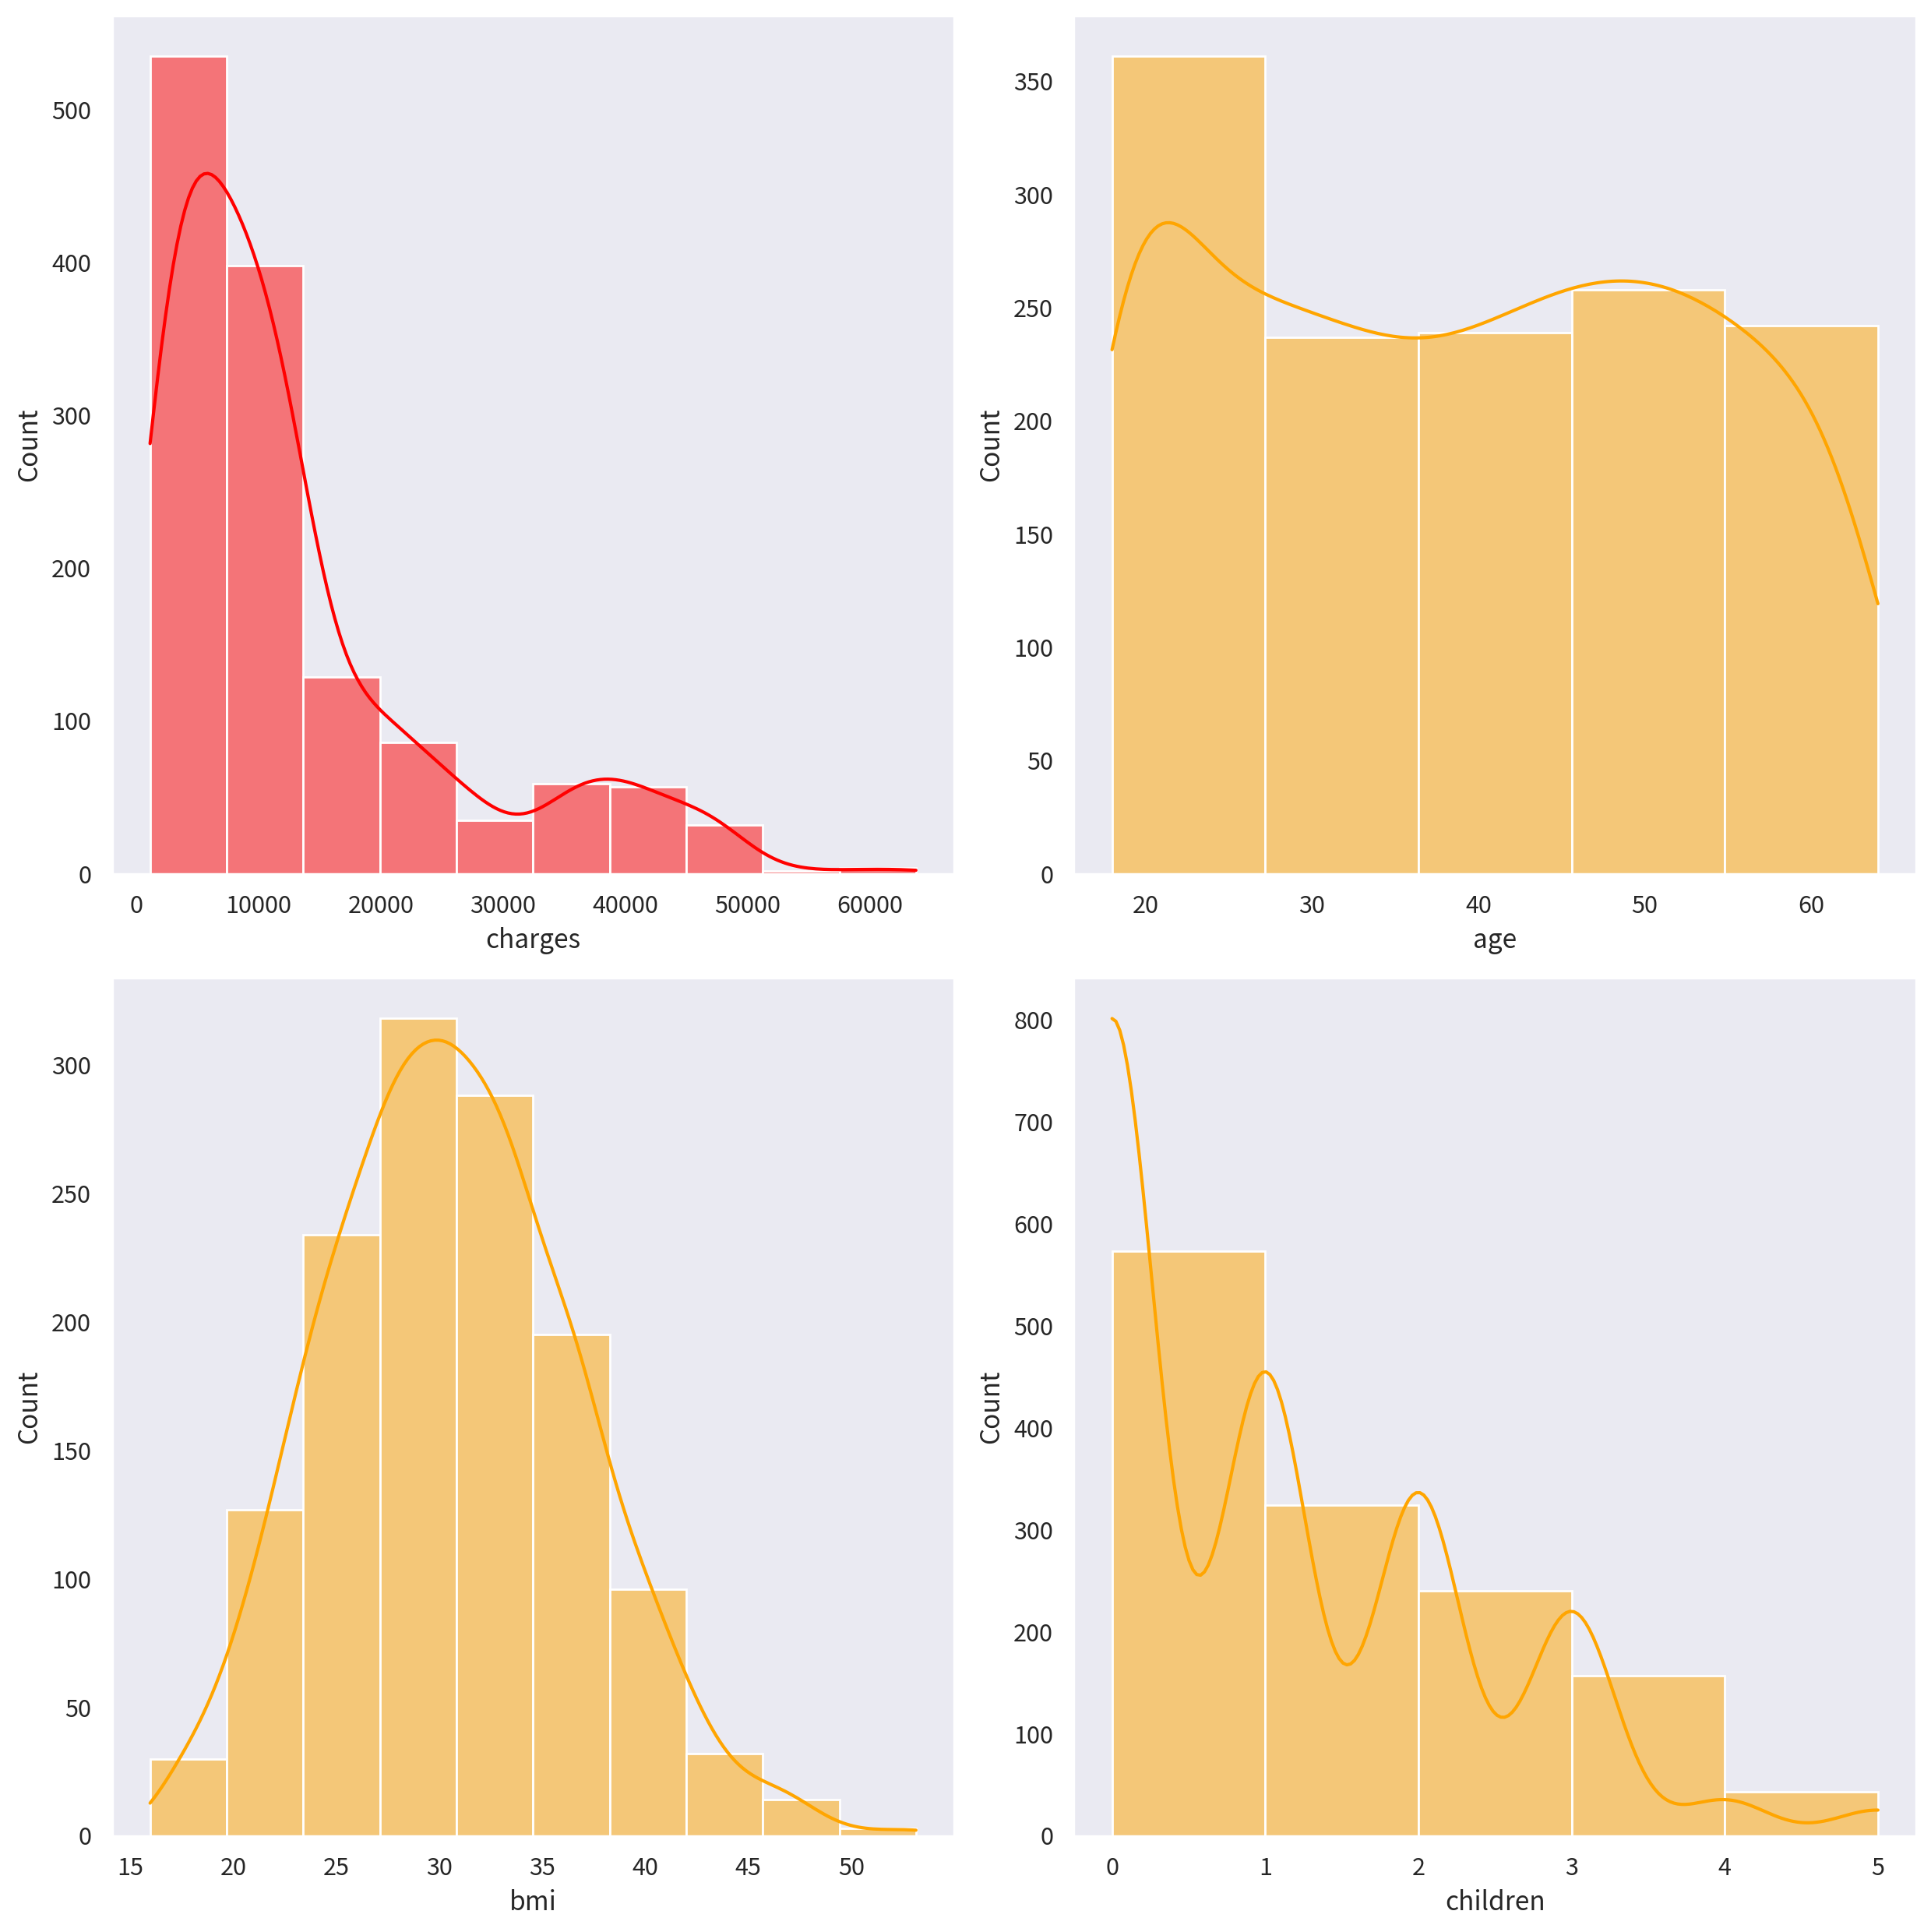

In [17]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='charges', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='age', bins=5, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='bmi', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='children', bins=5, kde=True, color='orange', ax=ax[1,1])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 대부분의 charges는 0~15000USD를 지불하는 듯 
    - 일부 고액을 내는 사람이 존재 (20000~50000)
    - 왼쪽으로 치우쳐져있음
- 나이대는 20대가 가장 많고 50대가 그 다음, 나머지 30,40,60대는 비슷함
- bmi 지수는 25~35 사이에 몰려있으며 정규 분포 형태를 띔
- 아이들은 1명 이하인 사람이 많은 것을 알 수 있음. 
    - 왼쪽으로 치우쳐져있음.